In [ ]:
!pip install contractions

In [ ]:
!pip install --upgrade tensorflow tensorflow-hub

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow_hub as hub

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Data and EDA

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [9]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [10]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

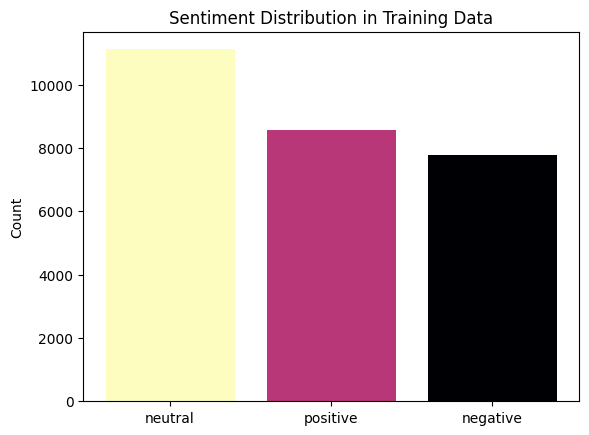

In [11]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [12]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [13]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [14]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [15]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub('`', "'",  text)
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [16]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [17]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [18]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Tokenize

In [19]:
train_data = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_data.append([row["sentiment"], tokens])

In [20]:
train_data[:3]

[[1, ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

In [21]:
test_data = []

for _, row in test_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_data.append([row["sentiment"], tokens])

In [22]:
test_data[:3]

[[1, ['last', 'session', 'of', 'the', 'day']],
 [2,
  ['shanghai',
   'is',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscrapers',
   'galore',
   'good',
   'tweeps',
   'in',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession',
   'hit',
   'veronique',
   'branquinho',
   'she',
   'has',
   'to',
   'quit',
   'her',
   'company',
   'such',
   'a',
   'shame']]]

### Remove stop words and Apply Lemmatizer

In [23]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    processed_tokens = []
    for token_list in tokens:
        label, words = token_list[0], token_list[1]
        filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords

        lemmatized_words = []
        for doc in nlp.pipe(filtered_words, disable=["parser", "ner"]):
            lemmatized_words.append(doc[0].lemma_)

        processed_tokens.append([label, lemmatized_words])
    return processed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
train_processed = preprocess_tokens(train_data)
train_processed[:5]

[[1, ['would', 'respond', 'go']],
 [0, ['sooo', 'sad', 'miss', 'san', 'diego']],
 [0, ['boss', 'bully']],
 [0, ['interview', 'leave', 'alone']],
 [0, ['son', 'could', 'put', 'release', 'already', 'buy']]]

In [25]:
test_processed = preprocess_tokens(test_data)
test_processed[:5]

[[1, ['last', 'session', 'day']],
 [2,
  ['shanghai',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscraper',
   'galore',
   'good',
   'tweep',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession', 'hit', 'veronique', 'branquinho', 'quit', 'company', 'shame']],
 [2, ['happy', 'birthday']],
 [2, ['like']]]

### Prepare Dataset

#### Training and Validation

In [91]:
train_text = [" ".join(tokens) for _, tokens in train_processed]
train_label = np.array([label for label, _ in train_processed])

In [114]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))

# Shuffle the entire dataset
train_dataset = train_dataset.shuffle(len(train_text), seed=42)

train_ratio = 0.9
total_size = len(train_text)
train_size = int(train_ratio * total_size)

train_data = train_dataset.take(train_size)
val_data = train_dataset.skip(train_size)

train_data = train_data.map(lambda x, y: (tf.squeeze(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(lambda x, y: (tf.squeeze(x), y)).batch(1).prefetch(tf.data.AUTOTUNE)

#### Get Vocab

In [115]:
unique_words = set()

for batch in train_data.as_numpy_iterator():
    text_batch, _ = batch
    for text in text_batch:
        words = text.decode().split()  # Convert tensor to string and split into words
        unique_words.update(words)

print(f"Vocabulary Size: {len(unique_words)}")

Vocabulary Size: 21281


#### Testing

In [116]:
test_text = [" ".join(tokens) for _, tokens in test_processed]
test_label = np.array([label for label, _ in test_processed])

In [138]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
test_data = test_dataset.shuffle(len(test_dataset)).batch(1)

## Data Prediction

### Embed text

In [118]:
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)

#### Example of how data is embedded

In [119]:
hub_layer(list(train_text[0][0]))

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.01637652, -0.06412444,  0.02356639,  0.04981329, -0.01245286,
         0.05542287, -0.02676301, -0.06290598,  0.03036505,  0.02712297,
         0.03397579,  0.00921929,  0.05229079,  0.0359453 , -0.04130445,
         0.03442498, -0.00624372,  0.07372443, -0.02496416,  0.0295514 ,
         0.05830863, -0.06326255,  0.01544765,  0.02696955, -0.07032253,
         0.02733462,  0.03314859, -0.0784882 ,  0.0681848 , -0.05367972,
        -0.03451416,  0.05175044, -0.00985313, -0.04545433,  0.07754658,
         0.03147165,  0.02733785,  0.05486463,  0.05701854, -0.06202932,
         0.02414836,  0.06595074, -0.0344983 ,  0.00810417, -0.00910548,
         0.06358559, -0.04650917, -0.00150456, -0.01968231, -0.03202097,
        -0.0184195 ,  0.04648848,  0.0664885 ,  0.0728073 ,  0.05726986,
         0.00617798, -0.01186068,  0.03731171,  0.0285284 , -0.00464502,
         0.02787894, -0.07256187, -0.05963167, -0.01533609,  0.03894921,
 

In [123]:
from tensorflow.keras.layers import Layer

# Wrap hub.KerasLayer inside a Custom Layer
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_layer):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

In [124]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=(), dtype=tf.string))  # Explicit input layer
model.add(HubEmbeddingLayer(hub_layer))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [134]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [135]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.6894 - loss: 0.7256 - val_accuracy: 0.7180 - val_loss: 0.6714
Epoch 2/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7098 - loss: 0.6755 - val_accuracy: 0.7467 - val_loss: 0.6148
Epoch 3/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7349 - loss: 0.6305 - val_accuracy: 0.7656 - val_loss: 0.5670
Epoch 4/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.7613 - loss: 0.5747 - val_accuracy: 0.7948 - val_loss: 0.5102
Epoch 5/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.7787 - loss: 0.5287 - val_accuracy: 0.8137 - val_loss: 0.4618


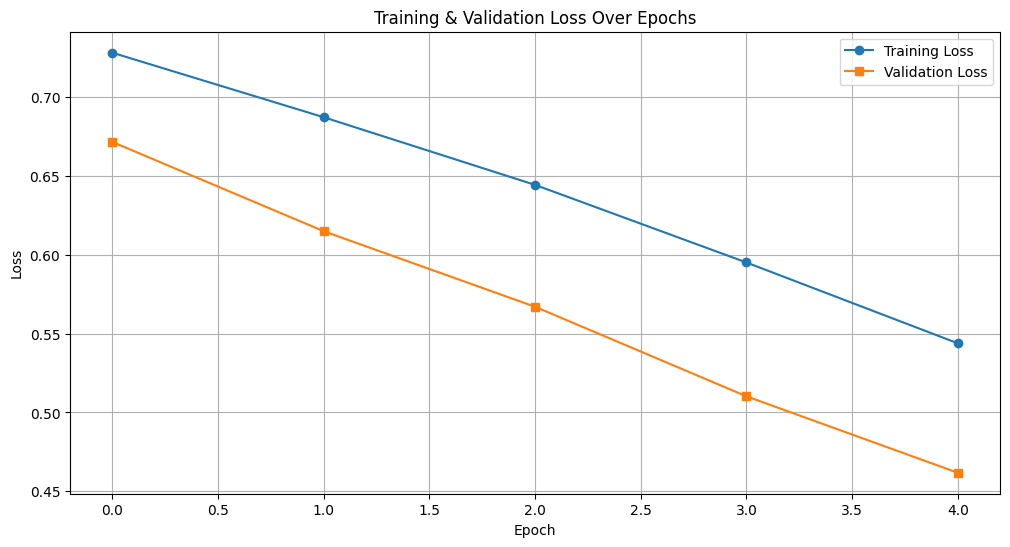

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training & Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [139]:
test_loss, test_acc = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

3534/3534 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6786 - loss: 0.8106
Test Loss: 0.8077
Test Accuracy: 0.6797
